# COSMOS2020 Photometric Redshifts estimation with EAZY

- Author: Shirui Wei
- Date: 2024-02-17
- Version: Phase 2
- Description: COSMOS2020(J. R. Weaver et al. 2022) results Replication , including data prepation, EAZY running and result analysis.

In [2]:
from astropy.io import fits
from astropy.io import fits,ascii,votable
from astropy import units as u 
from astropy import constants as const
from astropy import table
import eazy
import os
import sys
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

Failed to `import dust_attenuation`
Install my fork with $ pip install git+https://github.com/gbrammer/dust_attenuation.git


## Data Prepation
- Input Catalog
- EAZY files: Translate file

### Input Catalog
- Filter Definition and Visualization
- Remove invalid data
- Only select some columns, including ID, RA, DEC, filters which are used in The Farmer+EAZY and photo-z (J. R. Weaver et al. 2022 for validation).
- Magnitude bin

#### Filter Definition
The Farmer+EAZY only use 27 filters, which are:

['CFHT_u', 'CFHT_ustar', 'HSC_g', 'HSC_i', 'HSC_r', 'HSC_y', 'HSC_z', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4', 'SC_IA484', 'SC_IA527', 'SC_IA624', 'SC_IA679', 'SC_IA738', 'SC_IA767', 'SC_IB427', 'SC_IB464', 'SC_IB505', 'SC_IB574', 'SC_IB709', 'SC_IB827', 'UVISTA_H', 'UVISTA_J', 'UVISTA_Ks', 'UVISTA_Y']

In [2]:
catversion = 'Farmer'
fitversion = 'ez' 
flx = '_FLUX'  
flxerr = '_FLUXERR'  # catalog column for flux/mag error, just add 'ERR'
outflx = 'cgs' # 'cgs' or 'uJy'
# use https://github.com/cosmic-dawn/cosmos2020-readcat/blob/main/COSMOS2020_readcat.ipynb to preprocess catalog data.
catalog_raw_file = '/data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/COSMOS2020_Farmer_processed_0111.fits'

In [4]:
with fits.open(catalog_raw_file) as cat_hdu:
    cat_hdu.info()
    cat_data = cat_hdu[1].data
    cat_header = cat_hdu[1].columns.names

Filename: /data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/COSMOS2020_Farmer_processed_0111.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  PHASE3CATALOG    1 BinTableHDU   1144   746976R x 105C   [K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, E, E, E, E, E, E, E, E, E, E, E, E, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [6]:
# flux header:
flux_header = []
for k in cat_header:
    # only correct flux and fluxerr
    if k.endswith(flx):
        flux_header.append(k[:-5])
print(flux_header)
print(len(flux_header))

['CFHT_u', 'CFHT_ustar', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'UVISTA_NB118', 'SC_IB427', 'SC_IB464', 'SC_IA484', 'SC_IB505', 'SC_IA527', 'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 'SC_IA738', 'SC_IA767', 'SC_IB827', 'SC_NB711', 'SC_NB816', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4']
30


In [3]:
filt_name = ['GALEX_FUV', 'GALEX_NUV','CFHT_u','CFHT_ustar','HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_IB427', 'SC_IB464', 'SC_IA484', 'SC_IB505', 'SC_IA527', 'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 'SC_IA738', 'SC_IA767', 'SC_IB827', 'SC_NB711', 'SC_NB816', 'UVISTA_NB118', 'SC_B', 'SC_gp', 'SC_V', 'SC_rp', 'SC_ip','SC_zp', 'SC_zpp', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3','IRAC_CH4'] # micrometer  
farmer_ez_filt_not_use = ['GALEX_FUV', 'GALEX_NUV','SC_B', 'SC_gp', 'SC_V', 'SC_rp', 'SC_ip','SC_zp', 'SC_zpp','SC_NB711','SC_NB816','UVISTA_NB118']
filt_use = sorted(list(set(filt_name) - set(farmer_ez_filt_not_use)))
print("filters_use:")
print(filt_use)
print(len(filt_use))
filt_lambda = [0.1526,0.2307,0.3709,0.3858,0.4847,0.6219,0.7699,0.8894,0.9761,1.0216,1.2525,1.6466,2.1557,0.4266,0.4635,0.4851,0.5064,0.5261,0.5766,0.6232,0.6780,0.7073,0.7361,0.7694,0.8243,0.7121,0.8150,1.1909,0.4488,0.4804,0.5487,0.6305,0.7693,0.8978,0.9063,3.5686,4.5067,5.7788,7.9958]
filt_fwhm = [0.0224,0.07909,0.05181,0.05976,0.1383,0.1547,0.1471,0.0766,0.0786,0.0923,0.1718,0.2905,0.3074,0.02073,0.02182,0.02292,0.0231,0.02429,0.02729,0.03004,0.03363,0.03163,0.03235,0.03648,0.0343,0.0072,0.01198,0.01122,0.0892,0.1265,0.0954,0.1376,0.1497,0.0847,0.1335,0.7443,1.0119,1.4082,2.8796] 
filt_dict = {filt_name[i]:(filt_lambda[i]*1e4,filt_fwhm[i]*1e4) for i in range(len(filt_name))}

filters_use:
['CFHT_u', 'CFHT_ustar', 'HSC_g', 'HSC_i', 'HSC_r', 'HSC_y', 'HSC_z', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4', 'SC_IA484', 'SC_IA527', 'SC_IA624', 'SC_IA679', 'SC_IA738', 'SC_IA767', 'SC_IB427', 'SC_IB464', 'SC_IB505', 'SC_IB574', 'SC_IB709', 'SC_IB827', 'UVISTA_H', 'UVISTA_J', 'UVISTA_Ks', 'UVISTA_Y']
27


In [7]:
# sort all bands with their lambda.：
filt_dict_sort = dict(sorted(filt_dict.items(),key=lambda k:k[1][0]))
filt_dict_sort

{'GALEX_FUV': (1526.0000000000002, 224.0),
 'GALEX_NUV': (2307.0, 790.9),
 'CFHT_u': (3709.0, 518.1),
 'CFHT_ustar': (3857.9999999999995, 597.6),
 'SC_IB427': (4266.0, 207.29999999999998),
 'SC_B': (4488.0, 892.0),
 'SC_IB464': (4635.0, 218.2),
 'SC_gp': (4804.0, 1265.0),
 'HSC_g': (4847.0, 1383.0),
 'SC_IA484': (4851.0, 229.2),
 'SC_IB505': (5064.0, 231.0),
 'SC_IA527': (5261.0, 242.89999999999998),
 'SC_V': (5487.0, 954.0),
 'SC_IB574': (5766.0, 272.9),
 'HSC_r': (6219.0, 1547.0),
 'SC_IA624': (6232.0, 300.40000000000003),
 'SC_rp': (6304.999999999999, 1376.0),
 'SC_IA679': (6780.000000000001, 336.3),
 'SC_IB709': (7073.0, 316.3),
 'SC_NB711': (7121.0, 72.0),
 'SC_IA738': (7361.0, 323.49999999999994),
 'SC_ip': (7693.0, 1497.0),
 'SC_IA767': (7694.0, 364.8),
 'HSC_i': (7699.0, 1471.0),
 'SC_NB816': (8149.999999999999, 119.8),
 'SC_IB827': (8243.0, 343.0),
 'HSC_z': (8894.0, 766.0),
 'SC_zp': (8978.0, 847.0),
 'SC_zpp': (9063.0, 1335.0),
 'HSC_y': (9761.0, 786.0),
 'UVISTA_Y': (10216.

#### Visualization 
Check ranges of filters'band and check whether exists overlap

In [51]:
# remove data whose photo-z is nan:
cat_data = cat_data[~np.isnan(cat_data['photoz'])]

In [52]:
# validate mag and flux:
# remove flux whose is NaN or negative in order to visualization
nan_rows = np.zeros(len(cat_data), dtype=bool)
for field in cat_header:
    nan_rows |= np.isnan(cat_data[field])
    nan_rows |= cat_data[field]<0
# remove data whose flux and err are Nan
cat_data_exist = cat_data[~nan_rows]
len(cat_data_exist)

68257

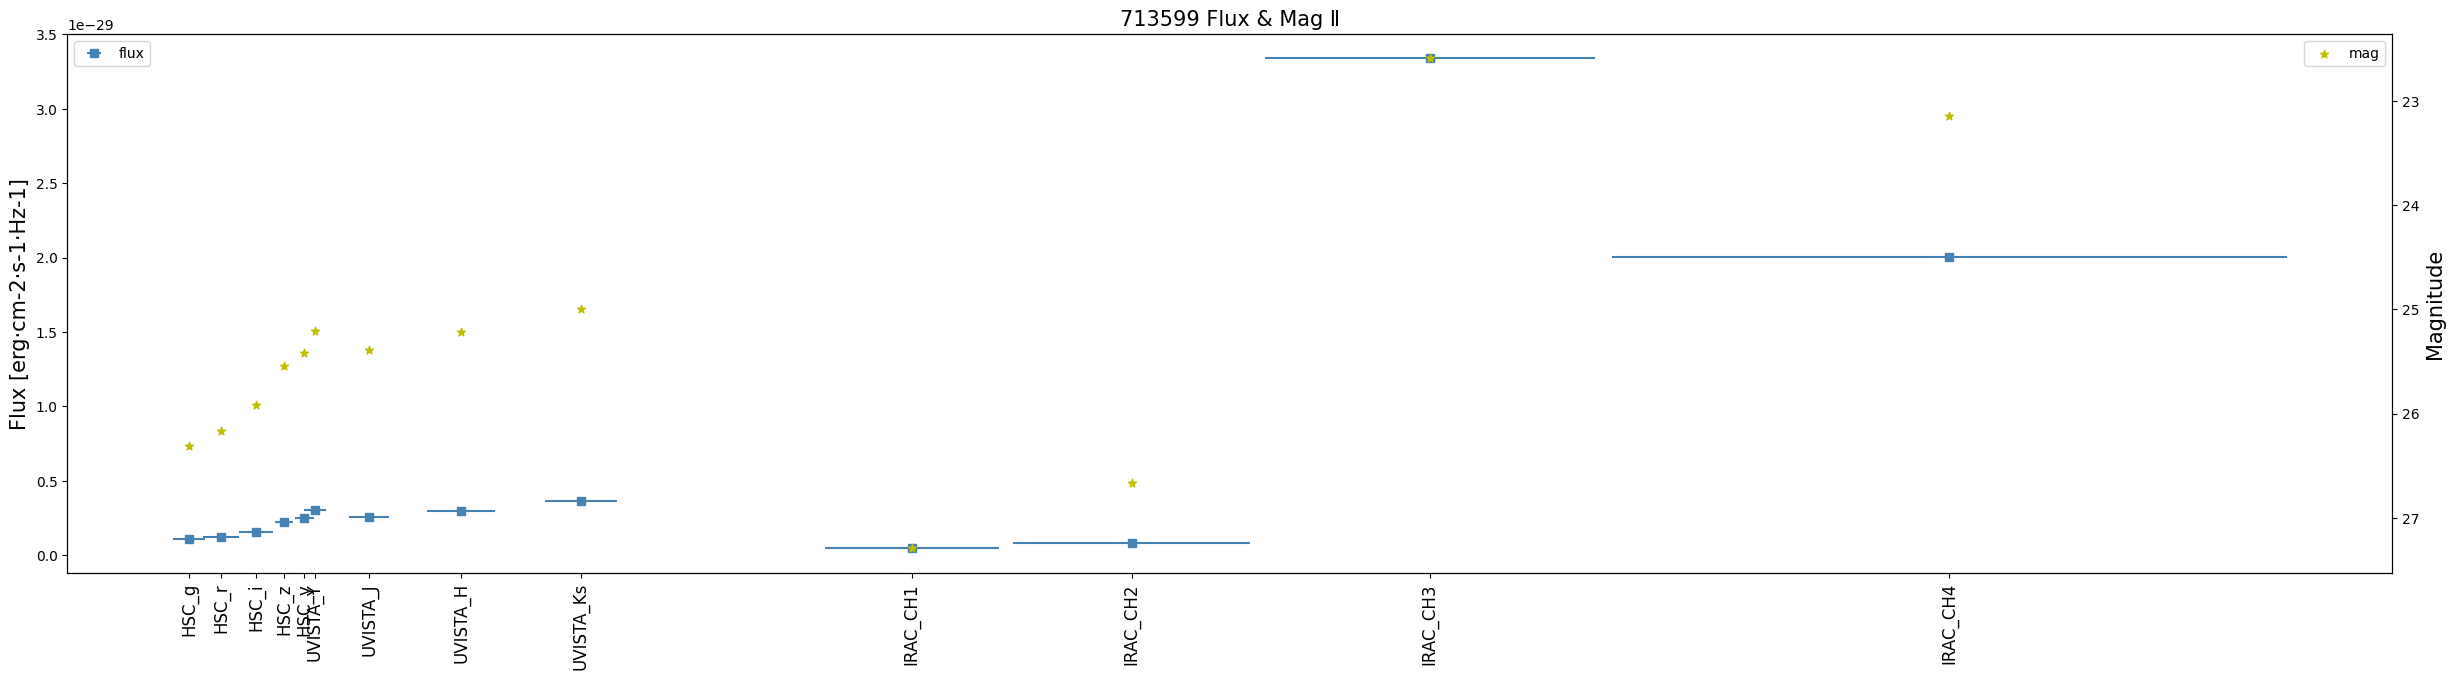

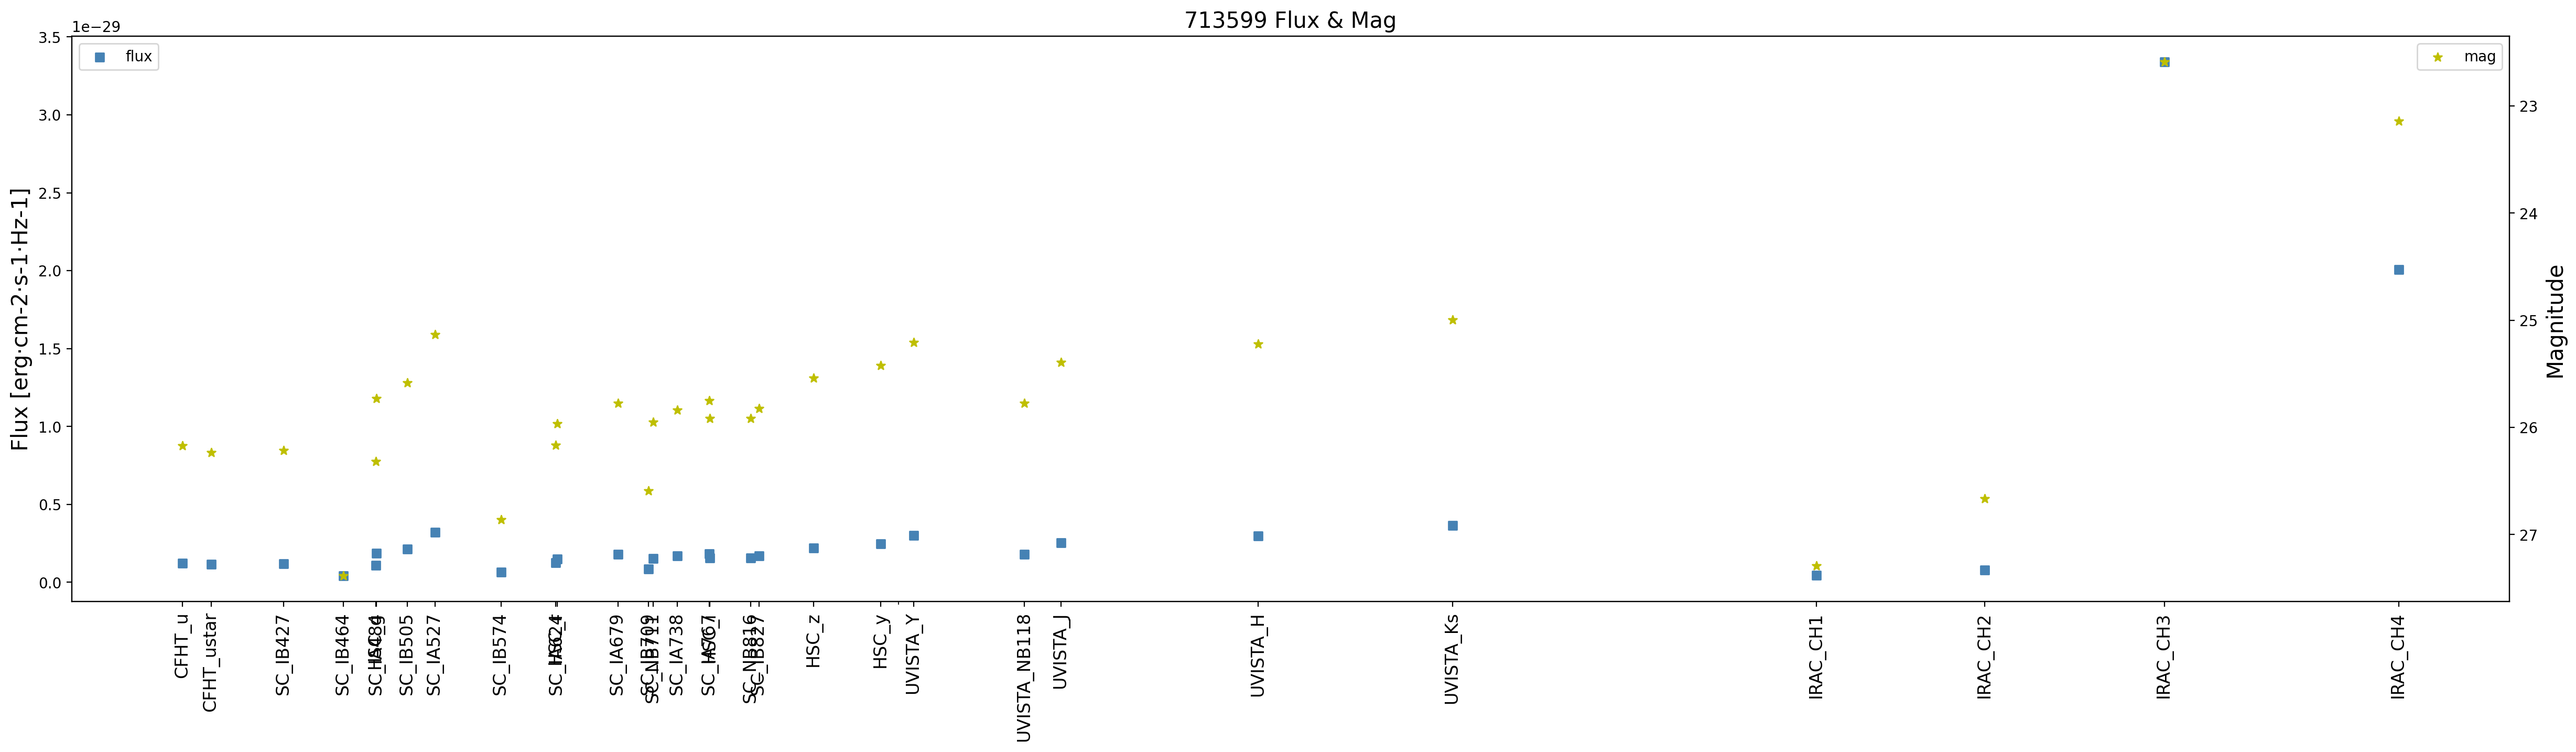

In [53]:
# Check the consistency between SED and magnitude
import random
def valid_SED_mag(cat_data_exist):
    """
    Check the consistency between SED and magnitude
    """
    ix = random.randint(0,len(cat_data_exist)-1)
    eval_data = cat_data_exist[ix]
    ID = eval_data['ID']
    eval_flux,eval_mag,eval_flux_lambda,eval_flux_fwhm,eval_filter = [],[],[],[],[]
    
    # because narrow bands and broad bands can't get on well in the same pic, so draw three pics.
    # first pic: bands exclude 'IRAC_CH'、'UVISTA_' and 'HSC_'
    for k in flux_header:
        if not k.startswith('IRAC_CH') and not k.startswith('UVISTA_') and not k.startswith('HSC_'):
            eval_flux.append(eval_data[k+flx])
            eval_mag.append(eval_data[k+'_MAG'])
            eval_flux_lambda.append(filt_dict[k][0])
            eval_flux_fwhm.append(filt_dict[k][1]/2)
            eval_filter.append(k)
    
    fig,ax1 = plt.subplots(figsize=(20,7),dpi=100)
    # plt.xscale('symlog')
    plt.xticks(eval_flux_lambda,eval_filter,rotation=90,size=15)
    ax1.errorbar(eval_flux_lambda,eval_flux,xerr=eval_flux_fwhm,color='steelblue',zorder=2,
                        marker='s', linestyle='None',label='flux')
    ax1.set_ylabel("Flux [erg·cm-2·s-1·Hz-1]",size=15)
    
    ax2 = ax1.twinx()
    ax2.scatter(eval_flux_lambda,eval_mag,marker='*',c='y',label='mag')
    ax2.set_ylabel("Magnitude",size=15)
    ax2.invert_yaxis()
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.title(f"{ID} Flux & Mag Ⅰ",size=15)
    # plt.show()
    plt.savefig('COSMOS2020_flux_mag_valid_1.png',dpi=100,bbox_inches = 'tight')
    # plt.close(fig)
    
    # seconde pic: only include 'IRAC_CH'、'UVISTA_' and 'HSC_'
    eval_flux,eval_mag,eval_flux_lambda,eval_flux_fwhm,eval_filter = [],[],[],[],[]
    for k in filt_use:
        if k.startswith('IRAC_CH') or k.startswith('UVISTA_') or k.startswith('HSC_'):
            eval_flux.append(eval_data[k+flx])
            eval_mag.append(eval_data[k+'_MAG'])
            eval_flux_lambda.append(filt_dict[k][0])
            eval_flux_fwhm.append(filt_dict[k][1]/2)
            eval_filter.append(k)
    
    fig,ax1 = plt.subplots(figsize=(30,7),dpi=100)
    # plt.xscale('symlog')
    plt.xticks(eval_flux_lambda,eval_filter,rotation=90,size=12)
    
    ax1.errorbar(eval_flux_lambda,eval_flux,xerr=eval_flux_fwhm,color='steelblue',zorder=2,
                        marker='s', linestyle='None',label='flux')
    ax1.set_ylabel("Flux [erg·cm-2·s-1·Hz-1]",size=15)
    
    ax2 = ax1.twinx()
    ax2.scatter(eval_flux_lambda,eval_mag,marker='*',c='y',label='mag')
    ax2.set_ylabel("Magnitude",size=15)
    ax2.invert_yaxis()
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.title(f"{ID} Flux & Mag Ⅱ",size=15)
    # plt.show()
    plt.savefig('COSMOS2020_flux_mag_valid_2.png',dpi=100,bbox_inches = 'tight')
    
    # third pic: all bands
    eval_flux,eval_mag,eval_flux_lambda,eval_flux_fwhm,eval_filter = [],[],[],[],[]
    for k in flux_header:
        eval_flux.append(eval_data[k+flx])
        eval_mag.append(eval_data[k+'_MAG'])
        eval_flux_lambda.append(filt_dict[k][0])
        eval_flux_fwhm.append(filt_dict[k][1]/2)
        eval_filter.append(k)
    
    fig,ax1 = plt.subplots(figsize=(30,7),dpi=200)
    plt.xscale('symlog')
    plt.xticks(eval_flux_lambda,eval_filter,rotation=90,size=12)
    
    ax1.scatter(eval_flux_lambda,eval_flux,color='steelblue',marker='s',label='flux')
    ax1.set_ylabel("Flux [erg·cm-2·s-1·Hz-1]",size=15)
    
    ax2 = ax1.twinx()
    ax2.scatter(eval_flux_lambda,eval_mag,marker='*',c='y',label='mag')
    ax2.set_ylabel("Magnitude",size=15)
    ax2.invert_yaxis()
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.title(f"{ID} Flux & Mag",size=15)
    # plt.show()
    plt.savefig('COSMOS2020_flux_mag_valid.png',dpi=200,bbox_inches = 'tight')


valid_SED_mag(cat_data_exist)

#### Remove invalid data
- Negative flux -> NaN
- NaN -> -90

In [18]:
# remove data whose photo-z is nan:
cat_data = cat_data[~np.isnan(cat_data['photoz'])]
# correct nagative flux to NaN
for k in cat_header:
    # only correct flux and fluxerr
    if k.endswith(flx):
        print(k)
        negative_rows = np.where(cat_data[k]<0)[0]
        print(negative_rows)
        cat_data[k][negative_rows] = np.NaN              

CFHT_u_FLUX
[    18     44     46 ... 671125 671128 671169]
CFHT_ustar_FLUX
[     9     29     44 ... 671138 671156 671169]
HSC_g_FLUX
[    76     81    170 ... 671135 671178 671181]
HSC_r_FLUX
[    44    203    237 ... 671181 671185 671188]
HSC_i_FLUX
[   298    340    344 ... 670972 670976 671188]
HSC_z_FLUX
[   298    340    802 ... 670972 670976 671188]
HSC_y_FLUX
[    46    154    271 ... 670983 671135 671188]
UVISTA_Y_FLUX
[     7      9     11 ... 671186 671187 671188]
UVISTA_J_FLUX
[     7      9     15 ... 671138 671153 671154]
UVISTA_H_FLUX
[    35     56     63 ... 671135 671138 671154]
UVISTA_Ks_FLUX
[    19     30    107 ... 671135 671145 671153]
UVISTA_NB118_FLUX
[     2      6     10 ... 671123 671187 671188]
SC_IB427_FLUX
[     7     15     18 ... 671169 671181 671188]
SC_IB464_FLUX
[     1      3      9 ... 671185 671186 671187]
SC_IA484_FLUX
[     9     15     19 ... 671181 671187 671188]
SC_IB505_FLUX
[     1     15     20 ... 671178 671181 671187]
SC_IA527_FLUX
[   

In [19]:
# fill nan with a Negative value:
NOT_OBS_THRESHOLD = -90
for k in cat_header:
    # only correct flux, fluxerr and MAG:
    if k.endswith(flxerr) or k.endswith(flx) or k.endswith('_MAG'):
        cat_data[k] = np.nan_to_num(cat_data[k],nan=NOT_OBS_THRESHOLD)
# overwrite:
cat_hdu[1].data = cat_data

In [20]:
# validate:
cat_data['CFHT_u_FLUX'][44]

-90.0

In [21]:
# select specific columns:
keep_columns = ['ID','RA','DEC']
for i in filt_use:
    keep_columns.append(i+flx)
    keep_columns.append(i+flxerr)
    keep_columns.append(i+'_MAG')
keep_columns.append('photoz')
keep_columns_idx = [cat_header.index(i) for i in keep_columns]

In [22]:
keep_columns

['ID',
 'RA',
 'DEC',
 'CFHT_u_FLUX',
 'CFHT_u_FLUXERR',
 'CFHT_u_MAG',
 'CFHT_ustar_FLUX',
 'CFHT_ustar_FLUXERR',
 'CFHT_ustar_MAG',
 'HSC_g_FLUX',
 'HSC_g_FLUXERR',
 'HSC_g_MAG',
 'HSC_i_FLUX',
 'HSC_i_FLUXERR',
 'HSC_i_MAG',
 'HSC_r_FLUX',
 'HSC_r_FLUXERR',
 'HSC_r_MAG',
 'HSC_y_FLUX',
 'HSC_y_FLUXERR',
 'HSC_y_MAG',
 'HSC_z_FLUX',
 'HSC_z_FLUXERR',
 'HSC_z_MAG',
 'IRAC_CH1_FLUX',
 'IRAC_CH1_FLUXERR',
 'IRAC_CH1_MAG',
 'IRAC_CH2_FLUX',
 'IRAC_CH2_FLUXERR',
 'IRAC_CH2_MAG',
 'IRAC_CH3_FLUX',
 'IRAC_CH3_FLUXERR',
 'IRAC_CH3_MAG',
 'IRAC_CH4_FLUX',
 'IRAC_CH4_FLUXERR',
 'IRAC_CH4_MAG',
 'SC_IA484_FLUX',
 'SC_IA484_FLUXERR',
 'SC_IA484_MAG',
 'SC_IA527_FLUX',
 'SC_IA527_FLUXERR',
 'SC_IA527_MAG',
 'SC_IA624_FLUX',
 'SC_IA624_FLUXERR',
 'SC_IA624_MAG',
 'SC_IA679_FLUX',
 'SC_IA679_FLUXERR',
 'SC_IA679_MAG',
 'SC_IA738_FLUX',
 'SC_IA738_FLUXERR',
 'SC_IA738_MAG',
 'SC_IA767_FLUX',
 'SC_IA767_FLUXERR',
 'SC_IA767_MAG',
 'SC_IB427_FLUX',
 'SC_IB427_FLUXERR',
 'SC_IB427_MAG',
 'SC_IB464_FLUX

In [23]:
cat_data_new = cat_data.columns[0:3] # ID RA DEC
for i in keep_columns_idx[3:]:
    cat_data_new=cat_data_new+cat_data.columns[i]

In [24]:
# write to catalog:
cat_hdu_new = fits.BinTableHDU.from_columns(cat_data_new)
cat_hdu_new.writeto('/data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/catalog_0208.fits',overwrite=True)

#### Magnitude bin

Split data by apparent magnitude bin, from HSC-i < 22.5 on the left to 25 < HSC-i < 27

bin ranges:

`[17,22.5],[22.5,24.0],[24.0,25.0],[25.0,27.0]`

(optional) bin ranges which fits for illustrating the behavior at faint magnitudes.

`[17,24.0],[24.0,25.0],[25.0,26.0],[25.0,27.0]`

In [3]:
# data which is processed by steps above
cat = table.Table.read('/data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/catalog_0208.fits',format='fits',hdu=1)
cat[[1,-1]]

ID,RA,DEC,CFHT_u_FLUX,CFHT_u_FLUXERR,CFHT_u_MAG,CFHT_ustar_FLUX,CFHT_ustar_FLUXERR,CFHT_ustar_MAG,HSC_g_FLUX,HSC_g_FLUXERR,HSC_g_MAG,HSC_i_FLUX,HSC_i_FLUXERR,HSC_i_MAG,HSC_r_FLUX,HSC_r_FLUXERR,HSC_r_MAG,HSC_y_FLUX,HSC_y_FLUXERR,HSC_y_MAG,HSC_z_FLUX,HSC_z_FLUXERR,HSC_z_MAG,IRAC_CH1_FLUX,IRAC_CH1_FLUXERR,IRAC_CH1_MAG,IRAC_CH2_FLUX,IRAC_CH2_FLUXERR,IRAC_CH2_MAG,IRAC_CH3_FLUX,IRAC_CH3_FLUXERR,IRAC_CH3_MAG,IRAC_CH4_FLUX,IRAC_CH4_FLUXERR,IRAC_CH4_MAG,SC_IA484_FLUX,SC_IA484_FLUXERR,SC_IA484_MAG,SC_IA527_FLUX,SC_IA527_FLUXERR,SC_IA527_MAG,SC_IA624_FLUX,SC_IA624_FLUXERR,SC_IA624_MAG,SC_IA679_FLUX,SC_IA679_FLUXERR,SC_IA679_MAG,SC_IA738_FLUX,SC_IA738_FLUXERR,SC_IA738_MAG,SC_IA767_FLUX,SC_IA767_FLUXERR,SC_IA767_MAG,SC_IB427_FLUX,SC_IB427_FLUXERR,SC_IB427_MAG,SC_IB464_FLUX,SC_IB464_FLUXERR,SC_IB464_MAG,SC_IB505_FLUX,SC_IB505_FLUXERR,SC_IB505_MAG,SC_IB574_FLUX,SC_IB574_FLUXERR,SC_IB574_MAG,SC_IB709_FLUX,SC_IB709_FLUXERR,SC_IB709_MAG,SC_IB827_FLUX,SC_IB827_FLUXERR,SC_IB827_MAG,UVISTA_H_FLUX,UVISTA_H_FLUXERR,UVISTA_H_MAG,UVISTA_J_FLUX,UVISTA_J_FLUXERR,UVISTA_J_MAG,UVISTA_Ks_FLUX,UVISTA_Ks_FLUXERR,UVISTA_Ks_MAG,UVISTA_Y_FLUX,UVISTA_Y_FLUXERR,UVISTA_Y_MAG,photoz
,deg,deg,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32
2,150.47797761902396,2.3291698582383837,3.144447089765112e-31,4.1784812556721314e-32,27.65613927139278,2.89929930651848e-31,3.5425529859610483e-32,27.744267370840177,3.811025731799039e-31,3.4621234980186913e-32,27.44739529722426,5.676675780586191e-31,4.515094977363543e-32,27.01476477373861,5.623959357339827e-31,4.7454133527499846e-32,27.024894566230724,4.201552220847346e-31,1.5165655916552863e-31,27.34147558566609,5.894009943109004e-31,6.835011770121409e-32,26.97397283959251,-90.0,1.2654578923982576e-31,-90.0,-90.0,1.0770404239184858e-31,-90.0,1.81827593082861e-29,4.282987998210688e-30,23.250850525360693,9.021908467540965e-30,5.04944830374546e-30,24.011753958459195,2.4697338365280586e-31,1.1695214951271415e-31,27.918374620449697,4.106341968439437e-31,1.0495081641689607e-31,27.366362215578427,5.37557574190893e-31,1.2363451530912433e-31,27.073937536371155,2.5912030119529212e-31,2.0947139183561545e-31,27.86624640045995,7.712165204206911e-31,1.7148092184475604e-31,26.682059189688964,-90.0,2.2996922077179204e-31,-90.0,7.107517608145738e-31,1.2004705976232783e-31,26.770705139290403,-90.0,2.138329793926657e-31,-90.0,-90.0,1.5568875868762594e-31,-90.0,2.7469907108035617e-31,1.7469982874966158e

In [4]:
bin_filter = 'HSC_i'
bin_range = [[17,22.5],[22.5,24.0],[24.0,25.0],[25.0,27.0]]

In [5]:
# remove data whose HSC_i band is -90.0 
NOT_OBS_THRESHOLD = -90.0
cat = cat[cat[bin_filter+'_MAG']!=NOT_OBS_THRESHOLD]
cat

ID,RA,DEC,CFHT_u_FLUX,CFHT_u_FLUXERR,CFHT_u_MAG,CFHT_ustar_FLUX,CFHT_ustar_FLUXERR,CFHT_ustar_MAG,HSC_g_FLUX,HSC_g_FLUXERR,HSC_g_MAG,HSC_i_FLUX,HSC_i_FLUXERR,HSC_i_MAG,HSC_r_FLUX,HSC_r_FLUXERR,HSC_r_MAG,HSC_y_FLUX,HSC_y_FLUXERR,HSC_y_MAG,HSC_z_FLUX,HSC_z_FLUXERR,HSC_z_MAG,IRAC_CH1_FLUX,IRAC_CH1_FLUXERR,IRAC_CH1_MAG,IRAC_CH2_FLUX,IRAC_CH2_FLUXERR,IRAC_CH2_MAG,IRAC_CH3_FLUX,IRAC_CH3_FLUXERR,IRAC_CH3_MAG,IRAC_CH4_FLUX,IRAC_CH4_FLUXERR,IRAC_CH4_MAG,SC_IA484_FLUX,SC_IA484_FLUXERR,SC_IA484_MAG,SC_IA527_FLUX,SC_IA527_FLUXERR,SC_IA527_MAG,SC_IA624_FLUX,SC_IA624_FLUXERR,SC_IA624_MAG,SC_IA679_FLUX,SC_IA679_FLUXERR,SC_IA679_MAG,SC_IA738_FLUX,SC_IA738_FLUXERR,SC_IA738_MAG,SC_IA767_FLUX,SC_IA767_FLUXERR,SC_IA767_MAG,SC_IB427_FLUX,SC_IB427_FLUXERR,SC_IB427_MAG,SC_IB464_FLUX,SC_IB464_FLUXERR,SC_IB464_MAG,SC_IB505_FLUX,SC_IB505_FLUXERR,SC_IB505_MAG,SC_IB574_FLUX,SC_IB574_FLUXERR,SC_IB574_MAG,SC_IB709_FLUX,SC_IB709_FLUXERR,SC_IB709_MAG,SC_IB827_FLUX,SC_IB827_FLUXERR,SC_IB827_MAG,UVISTA_H_FLUX,UVISTA_H_FLUXERR,UVISTA_H_MAG,UVISTA_J_FLUX,UVISTA_J_FLUXERR,UVISTA_J_MAG,UVISTA_Ks_FLUX,UVISTA_Ks_FLUXERR,UVISTA_Ks_MAG,UVISTA_Y_FLUX,UVISTA_Y_FLUXERR,UVISTA_Y_MAG,photoz
,deg,deg,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,erg / (Hz s cm2),erg / (Hz s cm2),,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32
1,150.47759181348482,2.3289280599580477,1.4286775124802996e-30,4.1863488283601616e-32,26.01266447763064,1.4485867931159773e-30,3.566769095834382e-32,25.997638696538726,1.3474227381787193e-30,3.4682673072330925e-32,26.076240320166857,1.3897415135565863e-30,4.5610206599078234e-32,26.04266492324113,1.4795410512313217e-30,4.804885971761918e-32,25.974682451087865,1.9944042975888768e-30,1.512743701028521e-31,25.6504669966885,1.5448364617163439e-30,6.886879564422908e-32,25.92779372188164,2.168535758023281e-30,1.2499986182277433e-31,25.559583530416873,3.5984373713499364e-30,1.0825896424508906e-31,25.009715128865995,1.258744098882556e-29,4.541589826168867e-30,23.65015638112312,-90.0,4.837822530255619e-30,-90.0,1.2057374035564531e-30,1.092360337920414e-31,26.196868166236534,1.0654780465733754e-30,1.0498184500685152e-31,26.331138735475726,1.4864385724434755e-30,1.23619798160566e-31,25.96963258362164,1.7113429328571295e-30,2.0911133863609155e-31,25.81665738566766,1.0496561418077242e-30,1.719570821743163e-31,26.347382371785464,1.2600610033094592e-30,2.311749586308766e-31,26.149021072207375,1.3148111994447626e-30,1.2002042775295136e-31,26.102841513232296,3.451427775580982e-30,2.1563623918011026e-31,

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

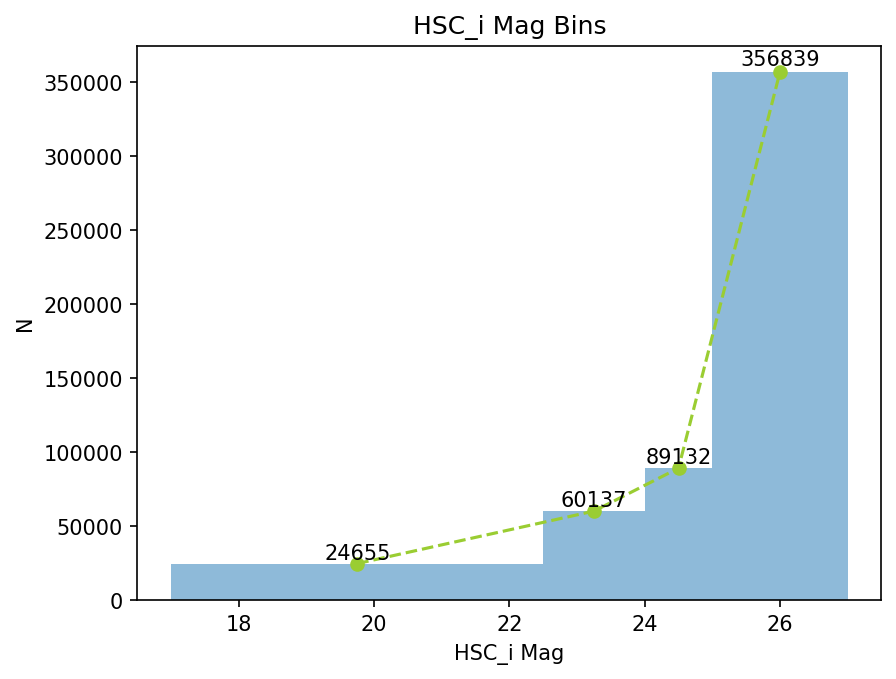

In [47]:
# Histogram
fig,ax = plt.subplots(dpi=150)
bin_num = [17,22.5,24.0,25.0,27.0]
hist = ax.hist(cat[bin_filter+'_MAG'],bins=bin_num,alpha=0.5)
bin_center = []
# counting：
for i in range(len(hist[0])):
    bin_center.append((hist[1][i]+hist[1][i+1])/2)
    plt.text((hist[1][i]+hist[1][i+1])/2,hist[0][i]*1.005,int(hist[0][i]),ha='center',va='bottom')
ax.plot(bin_center,hist[0],marker='o',color='yellowgreen',linestyle='--')
plt.xlabel("HSC_i Mag")
plt.ylabel("N")
plt.title("HSC_i Mag Bins")
plt.savefig('./img/bins.png')
plt.show()

In [22]:
# Magnitude bin:
cat_bin_1 = cat[(cat[bin_filter+'_MAG']<22.5) & (cat[bin_filter+'_MAG']>=17)]
cat_bin_2 = cat[(cat[bin_filter+'_MAG']>=22.5) & (cat[bin_filter+'_MAG']<24.0)]
cat_bin_3 = cat[(cat[bin_filter+'_MAG']>=24.0) & (cat[bin_filter+'_MAG']<25.0)]
cat_bin_4 = cat[(cat[bin_filter+'_MAG']>=25.0) & (cat[bin_filter+'_MAG']<=27.0)]

In [48]:
print(len(cat_bin_1),len(cat_bin_2),len(cat_bin_3),len(cat_bin_4))

24655 60137 89132 356839


In [50]:
# Binning data write to catalog
cat_bin_1.write('/data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/catalog_0208_bin1.fits',overwrite=True)
cat_bin_2.write('/data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/catalog_0208_bin2.fits',overwrite=True)
cat_bin_3.write('/data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/catalog_0208_bin3.fits',overwrite=True)
cat_bin_4.write('/data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/catalog_0208_bin4.fits',overwrite=True)

### Translate file
match filters used in COSMOS2020 with EAZY FILTER.RES.latest.info

rename columns to meet EAZY'requirements.

In [11]:
# check fits header
cat = table.Table.read('/data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/catalog_0208_bin1.fits',format='fits',hdu=1)
cat.keys()

['ID',
 'RA',
 'DEC',
 'CFHT_u_FLUX',
 'CFHT_u_FLUXERR',
 'CFHT_u_MAG',
 'CFHT_ustar_FLUX',
 'CFHT_ustar_FLUXERR',
 'CFHT_ustar_MAG',
 'HSC_g_FLUX',
 'HSC_g_FLUXERR',
 'HSC_g_MAG',
 'HSC_i_FLUX',
 'HSC_i_FLUXERR',
 'HSC_i_MAG',
 'HSC_r_FLUX',
 'HSC_r_FLUXERR',
 'HSC_r_MAG',
 'HSC_y_FLUX',
 'HSC_y_FLUXERR',
 'HSC_y_MAG',
 'HSC_z_FLUX',
 'HSC_z_FLUXERR',
 'HSC_z_MAG',
 'IRAC_CH1_FLUX',
 'IRAC_CH1_FLUXERR',
 'IRAC_CH1_MAG',
 'IRAC_CH2_FLUX',
 'IRAC_CH2_FLUXERR',
 'IRAC_CH2_MAG',
 'IRAC_CH3_FLUX',
 'IRAC_CH3_FLUXERR',
 'IRAC_CH3_MAG',
 'IRAC_CH4_FLUX',
 'IRAC_CH4_FLUXERR',
 'IRAC_CH4_MAG',
 'SC_IA484_FLUX',
 'SC_IA484_FLUXERR',
 'SC_IA484_MAG',
 'SC_IA527_FLUX',
 'SC_IA527_FLUXERR',
 'SC_IA527_MAG',
 'SC_IA624_FLUX',
 'SC_IA624_FLUXERR',
 'SC_IA624_MAG',
 'SC_IA679_FLUX',
 'SC_IA679_FLUXERR',
 'SC_IA679_MAG',
 'SC_IA738_FLUX',
 'SC_IA738_FLUXERR',
 'SC_IA738_MAG',
 'SC_IA767_FLUX',
 'SC_IA767_FLUXERR',
 'SC_IA767_MAG',
 'SC_IB427_FLUX',
 'SC_IB427_FLUXERR',
 'SC_IB427_MAG',
 'SC_IB464_FLUX

In [15]:
# relationships between filters and EAZY filter res
cosmos_eazy_filter = {}
cosmos_eazy_filter['CFHT_u'] = 348
cosmos_eazy_filter['CFHT_ustar'] = 417

cosmos_eazy_filter['HSC_g'] = 314
cosmos_eazy_filter['HSC_r'] = 315
cosmos_eazy_filter['HSC_i'] = 316
cosmos_eazy_filter['HSC_z'] = 317
cosmos_eazy_filter['HSC_y'] = 318

cosmos_eazy_filter['SC_IA484'] = 184
cosmos_eazy_filter['SC_IA527'] = 186
cosmos_eazy_filter['SC_IA624'] = 190
cosmos_eazy_filter['SC_IA679'] = 192
cosmos_eazy_filter['SC_IA738'] = 194
cosmos_eazy_filter['SC_IA767'] = 418
cosmos_eazy_filter['SC_IB427'] = 181
cosmos_eazy_filter['SC_IB464'] = 183
cosmos_eazy_filter['SC_IB505'] = 185
cosmos_eazy_filter['SC_IB574'] = 188
cosmos_eazy_filter['SC_IB709'] = 193
cosmos_eazy_filter['SC_IB827'] = 197


cosmos_eazy_filter['UVISTA_Y']=256
cosmos_eazy_filter['UVISTA_J']=257
cosmos_eazy_filter['UVISTA_H']=258
cosmos_eazy_filter['UVISTA_Ks']=259

cosmos_eazy_filter['IRAC_CH1'] = 18
cosmos_eazy_filter['IRAC_CH2'] = 19
cosmos_eazy_filter['IRAC_CH3'] = 20
cosmos_eazy_filter['IRAC_CH4'] = 21

In [17]:
# translate file:
with open('/data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/cosmos2020.translate','w') as trans_file:
    for key in cat.keys():
        if key in ['ID','RA','DEC']:
            trans = key.lower()
        elif key == 'photoz':
            trans = 'z_spec'
        else:
            if key.endswith(flxerr):
                key_filter = key[:-8]
                trans = 'E'+str(cosmos_eazy_filter[key_filter])
            elif key.endswith(flx):
                key_filter = key[:-5]
                trans = 'F'+str(cosmos_eazy_filter[key_filter])
            elif key.endswith('_MAG'):
                continue
        trans_file.write(f'{key} {trans}\n')

## Run EAZY
- file: translate_file and parameter file which has been written in advance, according to J. R. Weaver et al. 2022
- select samples
- fit catalog, compute z_phot and other parameters like mass, rest-frame color and save all results.

In [2]:
param_file ='/data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/cosmos2020.param.default'
translate_file = '/data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/cosmos2020.translate'

In [20]:
# # if it's the first time to initialize templates:
# # Run EAZY
# pz_obj = eazy.photoz.PhotoZ(param_file=param_file, translate_file=translate_file, zeropoint_file=None, 
#                           params={}, load_prior=False, load_products=False)
# # save template_data in order to to save time
# np.save('/data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/template_data.npy',pz_obj.tempfilt.tempfilt)

Read default param file: /data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/cosmos2020.param.default
Read CATALOG_FILE: /data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/catalog_0208_bin1.fits
   >>> NOBJ = 24655
CFHT_u_FLUX CFHT_u_FLUXERR (348): CFHT_Megaprime.u_sdss.dat-cfh9302
CFHT_ustar_FLUX CFHT_ustar_FLUXERR (417): CFHT/MegaPrime_u*
HSC_g_FLUX HSC_g_FLUXERR (314): g_HSC.txt
HSC_i_FLUX HSC_i_FLUXERR (316): i_HSC.txt
HSC_r_FLUX HSC_r_FLUXERR (315): r_HSC.txt
HSC_y_FLUX HSC_y_FLUXERR (318): y_HSC.txt
HSC_z_FLUX HSC_z_FLUXERR (317): z_HSC.txt
IRAC_CH1_FLUX IRAC_CH1_FLUXERR ( 18): IRAC/irac_tr1_2004-08-09.dat
IRAC_CH2_FLUX IRAC_CH2_FLUXERR ( 19): IRAC/irac_tr2_2004-08-09.dat
IRAC_CH3_FLUX IRAC_CH3_FLUXERR ( 20): IRAC/irac_tr3_2004-08-09.dat
IRAC_CH4_FLUX IRAC_CH4_FLUXERR ( 21): IRAC/irac_tr4_2004-08-09.dat
SC_IA484_FLUX SC_IA484_FLUXERR (184): Subaru_MB/IA484.dat
SC_IA527_FLUX SC_IA527_FLUXERR (186): Subaru_MB/IA527.dat
SC_IA624_FLUX SC_IA624

100%|██████████| 17/17 [09:37<00:00, 33.99s/it]  


Template   0: fsps_alpha_bin0_Av0.0.fits (NZ=14).
Template   1: fsps_alpha_bin0_Av0.5.fits (NZ=14).
Template   2: fsps_alpha_bin1_Av0.0.fits (NZ=14).
Template   3: fsps_alpha_bin1_Av0.5.fits (NZ=14).
Template   4: fsps_alpha_bin1_Av1.0.fits (NZ=14).
Template   5: fsps_alpha_bin1_Av2.0.fits (NZ=14).
Template   6: fsps_alpha_bin1_Av3.0.fits (NZ=14).
Template   7: spline_age0.31_av0.0.fits (NZ=14).
Template   8: spline_age0.31_av1.0.fits (NZ=14).
Template   9: spline_age0.31_av2.0.fits (NZ=14).
Template  10: spline_age0.62_av0.0.fits (NZ=14).
Template  11: spline_age0.62_av1.0.fits (NZ=14).
Template  12: spline_age0.62_av2.5.fits (NZ=14).
Template  13: spline_age1.76_av0.0.fits (NZ=14).
Template  14: spline_age1.76_av1.0.fits (NZ=14).
Template  15: spline_age7.18_av0.0.fits (NZ=14).
Template  16: spline_age0.91_av0.0.fits (NZ=14).
Process templates: 578.870 s


239it [00:01, 144.37it/s]


In [3]:
# if there's template data already:
tempfilt_data = np.load('/data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/template_data.npy')
# Run EAZY
pz_obj = eazy.photoz.PhotoZ(param_file=param_file, translate_file=translate_file, zeropoint_file=None, 
                          params={}, load_prior=False, load_products=False,tempfilt_data = tempfilt_data )

Read default param file: /data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/cosmos2020.param.default
Read CATALOG_FILE: /data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/catalog_0208_bin4.fits
   >>> NOBJ = 356839
CFHT_u_FLUX CFHT_u_FLUXERR (348): CFHT_Megaprime.u_sdss.dat-cfh9302
CFHT_ustar_FLUX CFHT_ustar_FLUXERR (417): CFHT/MegaPrime_u*
HSC_g_FLUX HSC_g_FLUXERR (314): g_HSC.txt
HSC_i_FLUX HSC_i_FLUXERR (316): i_HSC.txt
HSC_r_FLUX HSC_r_FLUXERR (315): r_HSC.txt
HSC_y_FLUX HSC_y_FLUXERR (318): y_HSC.txt
HSC_z_FLUX HSC_z_FLUXERR (317): z_HSC.txt
IRAC_CH1_FLUX IRAC_CH1_FLUXERR ( 18): IRAC/irac_tr1_2004-08-09.dat
IRAC_CH2_FLUX IRAC_CH2_FLUXERR ( 19): IRAC/irac_tr2_2004-08-09.dat
IRAC_CH3_FLUX IRAC_CH3_FLUXERR ( 20): IRAC/irac_tr3_2004-08-09.dat
IRAC_CH4_FLUX IRAC_CH4_FLUXERR ( 21): IRAC/irac_tr4_2004-08-09.dat
SC_IA484_FLUX SC_IA484_FLUXERR (184): Subaru_MB/IA484.dat
SC_IA527_FLUX SC_IA527_FLUXERR (186): Subaru_MB/IA527.dat
SC_IA624_FLUX SC_IA62

239it [00:48,  4.92it/s]


In [9]:
# select certain samples in catalog to fit:
# all samples in normal
# (optional) split into 5 pieces while running data in 25.0<i<27.0 due to its huge volume.
pz_obj.set_sys_err(positive=True)
sample = np.isfinite(pz_obj.ZSPEC)
# (optional):
# sample1:
# sample[80000:-1] = False
# sample2:
# sample[0:80000] = False
# sample[160000:] = False
# sample3:
# sample[0:160000] = False
# sample[240000:] = False
# sample4:
# sample[0:240000] = False
# sample[320000:] = False
# sample5:
# sample[0:320000]=False
# sample[-1] = False 
len(sample)

Set sys_err = 0.01 (positive=True)


356839

In [12]:
# fit catalog:
pz_obj.fit_catalog(pz_obj.idx[sample], n_proc=8)

 37%|███▋      | 88/239 [04:35<02:25,  1.04it/s] 


 NNLS quitting on iteration count.


100%|██████████| 239/239 [12:02<00:00,  3.02s/it]


Compute best fits
fit_best: 6.9 s (n_proc=3,  NOBJ=35890)
Fit 733.7 s (n_proc=8, NOBJ=36838)


In [13]:
# compute other parameters and save result
# may cost a lot of time. Be patient to wait...
tab = pz_obj.standard_output()

Get best fit coeffs & best redshifts
fit_best: 31.4 s (n_proc=3,  NOBJ=35890)


/data/home/wsr/.conda/envs/COSMOS2020/lib/python3.10/site-packages/eazy/photoz.py:3847: RuntimeWarning: overflow encountered in exp
  pzcum = cumtrapz(np.exp(spl(zgrid_zoom)), x=zgrid_zoom, axis=1)


Get parameters (UBVJ=[153, 154, 155, 161], simple=False)


 29%|██▉       | 10360/35890 [01:05<02:40, 158.63it/s]


 NNLS quitting on iteration count.


100%|██████████| 35890/35890 [03:48<00:00, 157.40it/s]
/data/home/wsr/.conda/envs/COSMOS2020/lib/python3.10/site-packages/eazy/photoz.py:4112: RuntimeWarning: invalid value encountered in divide
  coeffs_norm = (coeffs_norm.T/coeffs_norm.sum(axis=1)).T
/data/home/wsr/.conda/envs/COSMOS2020/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/data/home/wsr/.conda/envs/COSMOS2020/lib/python3.10/site-packages/eazy/photoz.py:4147: RuntimeWarning: invalid value encountered in divide
  draws_norm = (draws_norm.T/draws_norm.sum(axis=2).T).T
/data/home/wsr/.conda/envs/COSMOS2020/lib/python3.10/site-packages/eazy/photoz.py:4477: RuntimeWarning: invalid value encountered in divide
  par_draws_table['ssfr'] = (par_draws_table['sfr'] /
 33%|███▎      | 11850/35890 [03:42<07:31, 53.21it/s]


 NNLS quitting on iteration count.


 94%|█████████▍| 33858/35890 [10:36<00:38, 52.98it/s]


 NNLS quitting on iteration count.


100%|██████████| 35890/35890 [11:15<00:00, 53.14it/s]


Abs Mag filters [271, 272, 274]
Rest-frame filters:
~~~~~~~~~~~~~~~~~~~ 
   0 RestUV/Tophat_1700_200.dat lambda_c= 1.6989e+03 AB-Vega=1.916 w95=190.7
   1 RestUV/Tophat_2200_200.dat lambda_c= 2.1993e+03 AB-Vega=1.691 w95=191.1
   2 RestUV/Tophat_2800_200.dat lambda_c= 2.7996e+03 AB-Vega=1.465 w95=191.2


100%|██████████| 4/4 [03:15<00:00, 48.76s/it] 
/data/home/wsr/.conda/envs/COSMOS2020/lib/python3.10/site-packages/eazy/photoz.py:3961: RuntimeWarning: divide by zero encountered in log10
  obsm = self.param.params['PRIOR_ABZP'] - 2.5*np.log10(rf[:,i,:])
/data/home/wsr/.conda/envs/COSMOS2020/lib/python3.10/site-packages/eazy/photoz.py:3961: RuntimeWarning: invalid value encountered in log10
  obsm = self.param.params['PRIOR_ABZP'] - 2.5*np.log10(rf[:,i,:])


 ... rest-frame flux: 195.3 s (n_proc=4,  NOBJ=35891)


In [14]:
# check result：
# photoz_data:
with fits.open('./Output/photz.data.fits') as res_hdu:
    res_hdu.info()
    z_best_data = res_hdu[1].data
    z_grid_data = res_hdu[2].data

Filename: ./Output/photz.data.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  ZBEST         1 ImageHDU         7   (356839,)   float32   
  2  ZGRID         1 ImageHDU         7   (239,)   float32   
  3  CHI2          1 ImageHDU        10   (239, 356839)   float32   
  4  COEFFS        1 ImageHDU        27   (17, 356839)   float32   


In [15]:
# (optional) since data in 25.0<i<27.0 has been splited before, saving process should be splited too.
# samples selection is defined before.
with fits.open('./Output/photz.data.fits') as res_hdu:
    hdul = fits.HDUList()
    hdul.append(res_hdu[0]) # primary
    # select samples:
    res_hdu[1].data = res_hdu[1].data[sample]
    hdul.append(res_hdu[1])
    
    hdul.append(res_hdu[2])
    
    # select samples:
    res_hdu[3].data = res_hdu[3].data[sample]
    hdul.append(res_hdu[3])
    # select samples:
    res_hdu[4].data = res_hdu[4].data[sample]
    hdul.append(res_hdu[4])
    
    hdul.writeto('./Output/photz_sample5.data.fits',overwrite=True)

In [16]:
# check whether contain only one part of all data.
hdu = fits.open('./Output/photz_sample5.data.fits')
hdu.info()

Filename: ./Output/photz_sample5.data.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  ZBEST         1 ImageHDU         7   (36838,)   float32   
  2  ZGRID         1 ImageHDU         7   (239,)   float32   
  3  CHI2          1 ImageHDU        10   (239, 36838)   float32   
  4  COEFFS        1 ImageHDU        27   (17, 36838)   float32   


In [17]:
# check result：
# photo_zout:
with fits.open('./Output/photz.zout.fits') as zout_hdu:
    zout_hdu.info()
    zout_header = zout_hdu[1].columns.names
    zout_data = zout_hdu[1].data

Filename: ./Output/photz.zout.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    499   356839R x 90C   [K, D, D, E, K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 5D, 5D, 5D]   


In [18]:
# (optional) since data in 25.0<i<27.0 has been splited before, saving process should be splited too.
# samples selection is defined before.
with fits.open('./Output/photz.zout.fits') as zout_hdu:
    hdul = fits.HDUList()
    hdul.append(zout_hdu[0]) # primary
    # select samples:
    zout_hdu[1].data = zout_hdu[1].data[sample]
    hdul.append(zout_hdu[1])
    
    hdul.writeto('./Output/photz_sample5.zout.fits',overwrite=True)

In [19]:
# check whether contain only one part of all data.
hdu = fits.open('./Output/photz_sample5.zout.fits')
hdu.info()

Filename: ./Output/photz_sample5.zout.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    499   36838R x 90C   [K, D, D, E, K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 5D, 5D, 5D]   


## Result analysis
- show fit
- z_phot vs z_spec

In [3]:
# already have output file
param_file ='/data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/cosmos2020.param.default'
translate_file = '/data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/cosmos2020.translate'
tempfilt_data = np.load('/data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/template_data.npy')
# Run EAZY
pz_obj = eazy.photoz.PhotoZ(param_file=param_file, translate_file=translate_file, zeropoint_file=None, 
                          params={}, load_prior=False, load_products=True,tempfilt_data = tempfilt_data )

Read default param file: /data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/cosmos2020.param.default
Read CATALOG_FILE: /data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/catalog_0208_bin4.fits
   >>> NOBJ = 356839
CFHT_u_FLUX CFHT_u_FLUXERR (348): CFHT_Megaprime.u_sdss.dat-cfh9302
CFHT_ustar_FLUX CFHT_ustar_FLUXERR (417): CFHT/MegaPrime_u*
HSC_g_FLUX HSC_g_FLUXERR (314): g_HSC.txt
HSC_i_FLUX HSC_i_FLUXERR (316): i_HSC.txt
HSC_r_FLUX HSC_r_FLUXERR (315): r_HSC.txt
HSC_y_FLUX HSC_y_FLUXERR (318): y_HSC.txt
HSC_z_FLUX HSC_z_FLUXERR (317): z_HSC.txt
IRAC_CH1_FLUX IRAC_CH1_FLUXERR ( 18): IRAC/irac_tr1_2004-08-09.dat
IRAC_CH2_FLUX IRAC_CH2_FLUXERR ( 19): IRAC/irac_tr2_2004-08-09.dat
IRAC_CH3_FLUX IRAC_CH3_FLUXERR ( 20): IRAC/irac_tr3_2004-08-09.dat
IRAC_CH4_FLUX IRAC_CH4_FLUXERR ( 21): IRAC/irac_tr4_2004-08-09.dat
SC_IA484_FLUX SC_IA484_FLUXERR (184): Subaru_MB/IA484.dat
SC_IA527_FLUX SC_IA527_FLUXERR (186): Subaru_MB/IA527.dat
SC_IA624_FLUX SC_IA62

239it [00:47,  4.98it/s]


Load products: /data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/Output/photz.zout.fits
 ... Fit templates at zout[z_phot] 
fit_best: 70.8 s (n_proc=14,  NOBJ=347025)


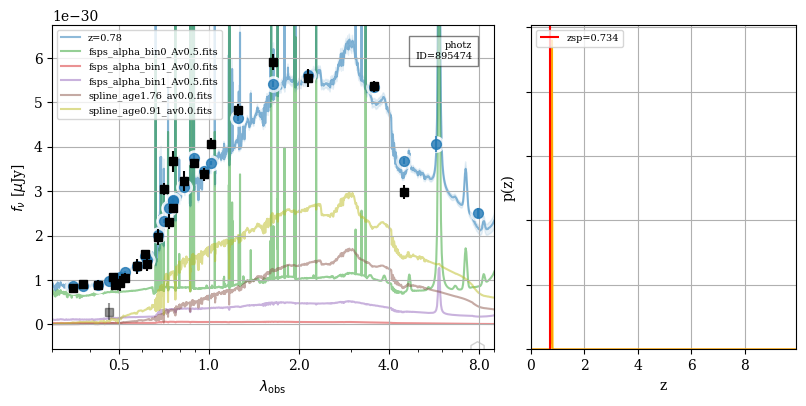

In [7]:
fig,data = pz_obj.show_fit(id=330000,id_is_idx=True, show_fnu=1,show_components=True)
fig.savefig('./img/phase2test1_bin4_fit.png')

In [22]:
# Compare forced fit at z_spec
for i in range(4):
    fig, data = pz_obj.show_fit(320000+i*100,id_is_idx=True, xlim=[0.2, 3], 
                        show_components=False,
                        template_color='steelblue', logpz=True, zr=[0,4])

    # Now show with z_spec
    axes = fig.axes[:1]
    res = pz_obj.show_fit(320000+i*100,id_is_idx=True, xlim=[0.2, 3], axes=axes,
                        zshow=pz_obj.ZSPEC[i*100], 
                        show_components=False,
                        template_color='r')

    axes[0].legend(loc='upper left')
    plt.savefig(f'./img/phase2test1_bin4_fitzspec{i}.png')
    plt.close(fig)

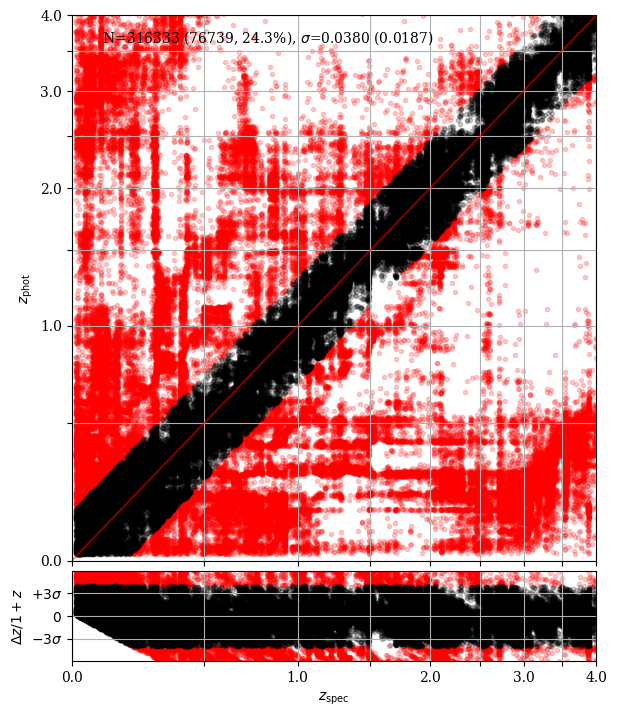

In [8]:
fig = pz_obj.zphot_zspec(include_errors=False)
plt.savefig('./img/phasetest1_bin4_zphoto_zspec.png')

In [4]:
# imitate COSMOS2020 pic:
def nmad(data):
    """
    Normalized median absolute deviation statistic
    
    Just a wrapper around `astropy.stats.mad_std`.
    """
    import astropy.stats
    #return 1.48*astropy.stats.median_absolute_deviation(arr)
    return astropy.stats.mad_std(data)

# ======================= modified by wsr =======================
# change bin color from black to blue
# add outlier lines.
# normal grid
def zphot_zspec(zphot, zspec, zlimits=None, zmin=0, zmax=6, axes=None, figsize=[5,5], minor=1, skip=2, selection=None, catastrophic_limit=0.15, title=None, min_zphot=0.02, alpha=0.2, extra_xlabel='', extra_ylabel='', xlabel=r'$\mathcal{z}_\mathrm{spec}$', ylabel=r'$\mathcal{z}_\mathrm{phot}$', label_pos=(0.05, 0.95), label_kwargs=dict(ha='left', va='top', fontsize=10), label_prefix='', format_axes=False, color='b', point_label=None, **kwargs):
    """
    Make zphot_zspec plot scaled by log(1+z) and show uncertainties

    Parameters
    ----------
    zphot : array-like
        Redshift on dependent axis

    zspec : array-like
        Redshift on independent axis

    zlimits : (N, 2) array
        Redshifts to use for photo-z errorbars, e.g. from 
        `~eazy.photoz.Photoz.pz_percentiles`, where `N` is the number of 
        objects as in `zphot` and `zspec`

    zmin, zmax : float
        Plot limits

    axes : `matplotlib` axes, None
        If specified, overplot in existing axes rather than generating a new
        plot.  For example, run the function once to generate the figure and
        then plot different points onto the existing axes:
        
        >>> fig = eazy.utils.zphot_spec(zphot, zspec, selection=sample1)
        >>> _ = eazy.utils.zphot_spec(zphot, zspec, selection=sample2, 
        >>>                           axes=fig.axes, color='b')

    figsize : list
        Figure canvas dimensions

    minor : float
        Axis tick interval

    skip : int
        Put axis labels every `skip` ticks

    selection : array-like
        Subsample selection (boolean or indices) applied as `zphot[selection]`

    catastrophic_limit : float
        Limit to define "catastrophic" failures, which is used for computing
        precision / outlier statistics printed on the plot

    title : str
        Title to add to the plot axes

    Returns
    -------
    fig : `matplotlib.figure.Figure`
        Figure object

    """
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    plt.rcParams['font.family'] = 'serif'

    clip = (zphot > min_zphot) & (zspec > zmin) & (zspec <= zmax)

    if selection is not None:
        clip &= selection
    
    bias = np.median(zphot-zspec)
    dz = (zphot-zspec)/(1+zspec)

    #izbest = np.argmin(self.fit_chi2, axis=1)

    clip_cat = (np.abs(dz) < catastrophic_limit)
    frac_cat = 1-(clip & clip_cat).sum() / clip.sum()
    NOUT = (clip & ~clip_cat).sum()
    
    gs = GridSpec(2,1, height_ratios=[6,1])
    
    fig = plt.figure(figsize=figsize,dpi=200)
    ax = fig.add_subplot(gs[0,0])
    
    if title is not None:
        ax.set_title(title)

    if zlimits is not None:
        yerr = np.log10(1+np.abs(zlimits.T - zphot))
        ax.errorbar(np.log10(1+zspec[clip & ~clip_cat]), 
                    np.log10(1+zphot[clip & ~clip_cat]), 
                    yerr=yerr[:,clip & ~clip_cat], marker='.', alpha=alpha, 
                    color='r', linestyle='None')
        
        ax.errorbar(np.log10(1+zspec[clip & clip_cat]), 
                    np.log10(1+zphot[clip & clip_cat]), 
                    yerr=yerr[:,clip & clip_cat], marker='.', alpha=alpha, 
                    color=color, linestyle='None', label=point_label)
    else:
        ax.scatter(zspec[clip & ~clip_cat],zphot[clip & ~clip_cat], marker='.', s=1,alpha=alpha, color='gray')
        # ax.hexbin(zspec[clip & ~clip_cat],zphot[clip & ~clip_cat],gridsize=900,bins='log',cmap='gray')
        # ax.scatter(zspec[clip & clip_cat], zphot[clip & clip_cat], marker='.', alpha=alpha, color=color, label=point_label)
        hb = ax.hexbin(zspec[clip & clip_cat], zphot[clip & clip_cat],gridsize=80,bins='log',cmap='Blues', label=point_label)
    
    # colorbar
    cb = fig.colorbar(hb,ax=ax,label='$\log_{10}(N)$',)
    
    xt = np.arange(zmin,zmax+1,minor)
    xtl = [str(i) for i in xt]

    # line
    ax.plot(xt, xt, color='r', alpha=0.5)
    # 0.15
    upper_line = [i+0.15*(1+i) for i in xt]
    ax.plot(xt,upper_line,color='r',alpha=0.3,linestyle='--')
    # -0.15
    lower_line = [i-0.15*(1+i) for i in xt]
    ax.plot(xt,lower_line,color='r',alpha=0.3,linestyle='--')


    ax.set_xlim(xt[0], xt[-1])
    ax.set_ylim(xt[0],xt[-1])

    ax.set_xticks(xt)
    ax.set_xticklabels(xtl)
    ax.set_xlabel(xlabel)
            
    ax.set_yticks(xt)
    ax.set_yticklabels(xtl)
    ax.set_ylabel(ylabel + extra_ylabel)

    sample_nmad = nmad(dz[clip])
    sample_cat_nmad = nmad(dz[clip & clip_cat])
    
    # grid
    plt.grid(color='gray',alpha=0.3,linewidth=0.3)

    if label_pos is not None:
        # msg = r'{label_prefix} N={N} ({NOUT}, {err_frac:4.1f}%), $\sigma$={sample_nmad:.4f} ({sample_cat_nmad:.4f})'
        mag_min = 25.0
        mag_max = 27.0
        
        msg = f'{mag_min} < i <{mag_max}\n $\eta$:{frac_cat*100:4.1f}% (NOUT/N = {NOUT}/{clip.sum()}) \n $\sigma$: {sample_nmad:.4f} ({sample_cat_nmad:.4f})\n b: {bias:.4f}'
        label_pos=(0.05, 0.75)
        ax.text(label_pos[0], label_pos[1], msg, transform=ax.transAxes)
        return fig

    else:
        return True

# ======================= modified by wsr =======================


In [5]:
def zphot_zspec_m(pz_obj, selection=None, min_zphot=0.02, zmin=0, zmax=6, include_errors=False, **kwargs):
    clip = (pz_obj.zbest > min_zphot) 
    clip &= (pz_obj.ZSPEC > zmin) & (pz_obj.ZSPEC <= zmax)
            
    if include_errors:
        zlimits = pz_obj.pz_percentiles(percentiles=[16,84], oversample=5,
                                      selection=clip)
    else:
        zlimits = None
            
    fig = zphot_zspec(pz_obj.zbest, pz_obj.ZSPEC, 
                          zlimits=zlimits, 
                          selection=selection, min_zphot=min_zphot, 
                          zmin=zmin, zmax=zmax, **kwargs)
    return fig

In [6]:
fig_i = zphot_zspec_m(pz_obj)
fig_i.savefig('./img/imit_cosmos2020/bin4.png',dpi=200)
plt.close(fig_i)

## Merge 25.0<i<27.0 data (Optional)

In [ ]:
hdu1 = fits.open('./Output/bin25.0-27.0/0-79999/photz.data.fits')
hdu1.info()

# sample 1
with fits.open('./Output/bin25.0-27.0/0-79999/photz_sample1.data.fits') as res_hdu:
    res_hdu.info()
    # ZBEST:
    hdu1[1].data[0:80000] = res_hdu[1].data[:80000]
    hdu1[1].data[-1] = res_hdu[1].data[-1]
    # CHI2:
    hdu1[3].data[0:80000] = res_hdu[3].data[:80000]
    hdu1[3].data[-1] = res_hdu[3].data[-1]
    # COEFFS:
    hdu1[4].data[0:80000] = res_hdu[4].data[:80000]
    hdu1[4].data[-1] = res_hdu[4].data[-1]

# sample 2
with fits.open('./Output/bin25.0-27.0/80000-159999/photz_sample2.data.fits') as res_hdu:
    res_hdu.info()
    # ZBEST:
    hdu1[1].data[80000:160000] = res_hdu[1].data[:]
    # CHI2:
    hdu1[3].data[80000:160000] = res_hdu[3].data[:]
    # COEFFS:
    hdu1[4].data[80000:160000] = res_hdu[4].data[:]

# sample 3
with fits.open('./Output/bin25.0-27.0/160000-239999/photz_sample3.data.fits') as res_hdu:
    res_hdu.info()
    # ZBEST:
    hdu1[1].data[160000:240000] = res_hdu[1].data[:]
    # CHI2:
    hdu1[3].data[160000:240000] = res_hdu[3].data[:]
    # COEFFS:
    hdu1[4].data[160000:240000] = res_hdu[4].data[:]

# sample 4
with fits.open('./Output/bin25.0-27.0/240000-319999/photz_sample4.data.fits') as res_hdu:
    res_hdu.info()
    # ZBEST:
    hdu1[1].data[240000:320000] = res_hdu[1].data[:]
    # CHI2:
    hdu1[3].data[240000:320000] = res_hdu[3].data[:]
    # COEFFS:
    hdu1[4].data[240000:320000] = res_hdu[4].data[:]

# sample 5
with fits.open('./Output/bin25.0-27.0/320000-356837/photz_sample5.data.fits') as res_hdu:
    res_hdu.info()
    # ZBEST:
    hdu1[1].data[320000:-1] = res_hdu[1].data[:]
    # CHI2:
    hdu1[3].data[320000:-1] = res_hdu[3].data[:]
    # COEFFS:
    hdu1[4].data[320000:-1] = res_hdu[4].data[:]
    

# save
hdu1.writeto('./Output/bin25.0-27.0/photz.data.fits')

In [ ]:
hdu2 = fits.open('./Output/bin25.0-27.0/0-79999/photz.zout.fits')
hdu2.info()

# sample 1
with fits.open('./Output/bin25.0-27.0/0-79999/photz_sample1.zout.fits') as res_hdu:
    res_hdu.info()
    hdu2[1].data[0:80000] = res_hdu[1].data[:80000]
    hdu2[1].data[-1] = res_hdu[1].data[-1]

# sample 2
with fits.open('./Output/bin25.0-27.0/80000-159999/photz_sample2.zout.fits') as res_hdu:
    res_hdu.info()
    hdu2[1].data[80000:160000] = res_hdu[1].data[:]

# sample 3
with fits.open('./Output/bin25.0-27.0/160000-239999/photz_sample3.zout.fits') as res_hdu:
    res_hdu.info()
    hdu2[1].data[160000:240000] = res_hdu[1].data[:]

# sample 4
with fits.open('./Output/bin25.0-27.0/240000-319999/photz_sample4.zout.fits') as res_hdu:
    res_hdu.info()
    hdu2[1].data[240000:320000] = res_hdu[1].data[:]

# sample 5
with fits.open('./Output/bin25.0-27.0/320000-356837/photz_sample5.zout.fits') as res_hdu:
    res_hdu.info()
    hdu2[1].data[320000:356838] = res_hdu[1].data[:]
# save 
hdu2.writeto('./Output/bin25.0-27.0/photz.zout.fits')
